In [1]:
"""Errors might remain if Kernel is not restarted"""
"""Changes to local modules might not update if Kernel is not restarted"""

'Changes to local modules might not update if Kernel is not restarted'

In [2]:
import numpy as np

""" Loading data: e.g. here, data is cleaned and coordinates are computed in module load_text_data"""
from load_text_data import Coords_Rows, Coords_Cols, ContDataFrame, columns_labels, rows_labels, D, Dr, Dc, row_val, col_val, dtp, ColName, RowName

""" Compute similarity and association metrics: e.g. here using modules bellow """
from Methods.Core.Generate_Distances import Similarity_Distance, Association_Distance

D_row_var = Similarity_Distance(Coords_Rows, method = "Euclidean")
D_col_var = Similarity_Distance(Coords_Cols, method = "Euclidean")

Coords = (Coords_Rows, Coords_Cols)
func = lambda Coords: np.exp(-Dr.dot(D.dot(Dc))) ### Pearson ratio - 1  #### here independent of the coordinates
D_assoc = Association_Distance(Coords, func)


The analysis was made on text vs. Verbal forms
The analysis was made on the whole text.
-----------------------------------------


In [3]:
"""Distane to origin Optional but must be set to None if not used"""
Orow = np.linalg.norm(Coords_Rows, axis = 1)
Ocols = np.linalg.norm(Coords_Cols, axis = 1)
"""If Distance to origin is set to None, then the corresponding norms of vectors pointing to the axes origin is not interpretable"""
#Orow = None
#Ocols = None

'If Distance to origin is set to None, then the corresponding norms of vectors pointing to the axes origin is not interpretable'

In [4]:
"""joint Euclidean embedding of row and column variables"""
from Methods.Core.qEmbedding import Euclidean_Embedding
M = D_row_var.shape[0]
N = D_col_var.shape[0]

### Parameters needed for Euclidean Embedding (See Paper) ####
c1, c2 = 1/4, 1/2 # Parameters for text graphs in MATH+ day cluster 2022
c3 = (2*c1 + M*c2 - 1)/M # choose this because this is the only one that works for Form = "SP", "PI"
c_dic = {"c1":c1, "c2":c2, "c3":c3} 
Coords, vareps = Euclidean_Embedding(D_row_var, D_col_var, Orow, Ocols, D_assoc, c_dic) 

Replacement matrix is PSD: success Euclidean embedding


In [5]:
"""Coordinate system"""
if (Orow is not None) or (Ocols is not None):
    Emb_Rows = Coords[:M, :]
    Emb_Cols = Coords[M+1:, :]
    Origin = Coords[M, :] 
else:
    Emb_Rows = Coords[:M, :]
    Emb_Cols = Coords[M:, :]
    Origin = np.zeros(Emb_Rows.shape[1])

In [6]:
"""Clustering of Similarity and Association patterns"""
from Methods.Core.Lower_dim import get_clusters
palette = "tab20" ## seaborn color palette
num_clust = N
Centred_Coords = Coords - Origin[np.newaxis, :]
#Centred_Cols = Emb_Cols - Origin[np.newaxis, :]
clust_labels, color_clustered = get_clusters(Coords, num_clust, palette, method = "Kmeans")#, init = Centred_Cols)

In [7]:
"""Lower Dimensional visualization of clusters using UMAP"""
from Methods.Core.Lower_dim import low_dim_coords
nb = 15 ### only for UMAP method for Egyptian texts data 
low_meth = "umap" # or sklearn.manifols methods: MDS, Isomap, TSNE 
Coords_manifold = low_dim_coords(Centred_Coords, dim=2, method  = low_meth, n_neighbors = nb, scale = False)  # scale = "pca", "standard", anything esle is taken as no scaling 
"""Kmeans and UMAP are already parameterized for reproducibility (random_state = 0 for both)."""
"""However, slight changes could still happen due to the optimization procedure and versions of these packages."""

"""Coordinate system """
if (Orow is not None) or (Ocols is not None):
    Rows_manifold = Coords_manifold[:M, :]
    Cols_manifold = Coords_manifold[M+1:, :]
    Origin_manifold = Coords_manifold[M, :] 
else:
    Rows_manifold = Coords_manifold[:M, :]
    Cols_manifold = Coords_manifold[M:, :]
    Origin_manifold = np.zeros(Coords_manifold.shape[1])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


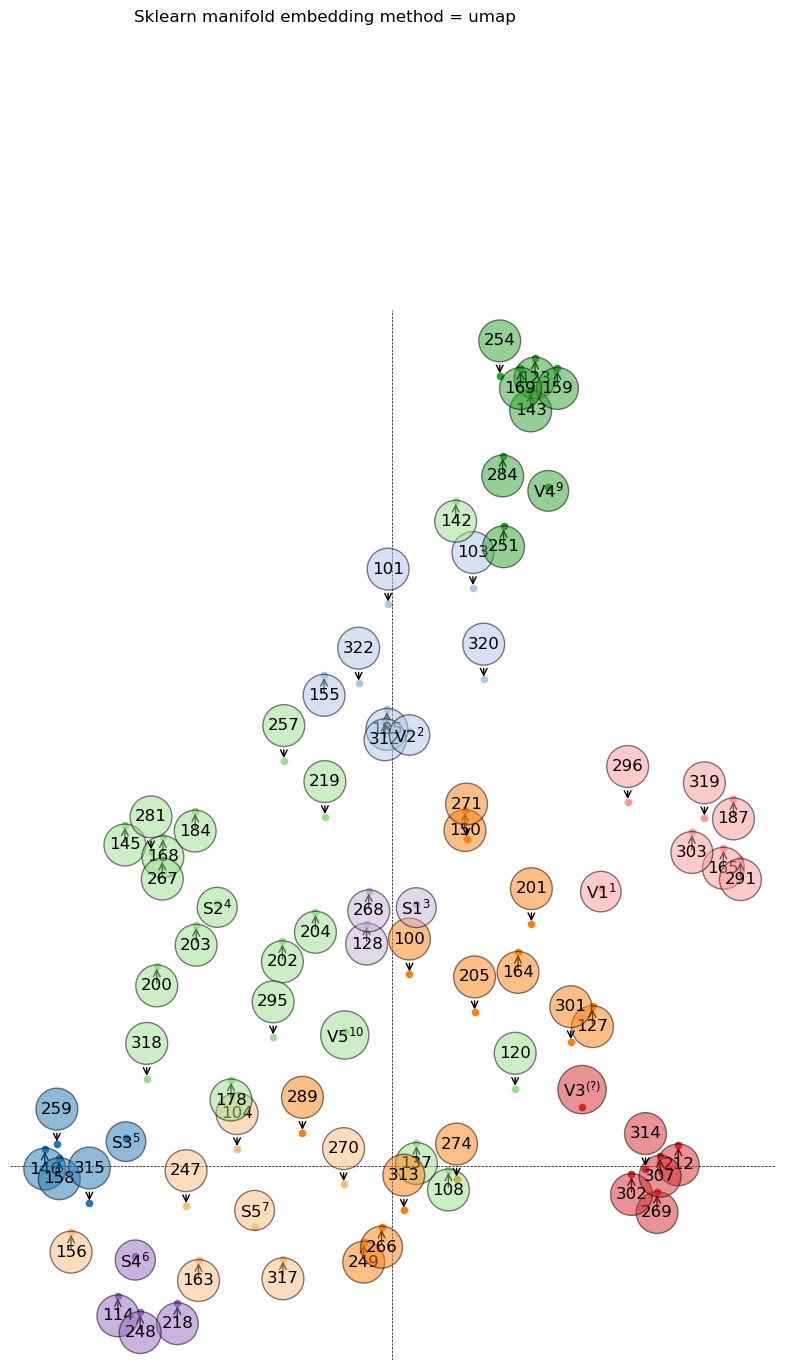

In [8]:
"""Plot and Save figure"""
from Methods.figure_settings import Display
Inertia = np.array([0, 1]) # not relevant for manifold
AllCols = ContDataFrame.columns
AllRows = ContDataFrame.index

col_rows = {rows_labels[ContDataFrame.index[i]]:color_clustered[i] for i in range(M)}

if (Orow is not None) or (Ocols is not None):
    col_cols = {columns_labels[ContDataFrame.columns[i]]:color_clustered[i+M+1] for i in range(N)}
else:
    col_cols = {columns_labels[ContDataFrame.columns[i]]:color_clustered[i+M] for i in range(N)}
    Origin_manifold = None # Not interpretable thus not plotted
col_to_use = (col_rows, col_cols)
marker_to_use = [("o",20),("o",20)]
fig, xy_rows, xy_cols, gs, center = Display(Rows_manifold, 
                                             Cols_manifold, 
                                             Inertia, 
                                             ContDataFrame,
                                             center = Origin_manifold, 
                                             rows_to_Annot = AllRows,  # row items to annotate, if None then no annotation (None if none)
                                             cols_to_Annot = AllCols,  # column items to annotate (None if none)
                                             Label_rows = rows_labels, # dictionary of labels respectivelly corresponding to the row items (None if none)
                                             Label_cols = columns_labels,     # dictionary of labels respectivelly corresponding to the column items that (None if none)
                                             markers = marker_to_use,# pyplot markertypes, markersize: [(marker for the row items, size), (marker for the columb items, size)] 
                                             col = col_to_use,        # pyplot colortypes : [color for the row items, color for the column items] 
                                             figtitle = "Sklearn manifold embedding method = %s"%low_meth, 
                                             outliers = (True, True),
                                             dtp = dtp,
                                             chosenAxes = np.array([0,1]), 
                                             show_inertia = False, 
                                             model={"model":"stand"}, 
                                             ColName = ColName, 
                                             RowName = RowName,
                                             lims = False) # crop fig

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
pdf= PdfPages("Figures/fig%s_%s_UMAP"%(col_val,row_val)+".pdf")
pdf.savefig(fig, bbox_inches = "tight")
pdf.close()
plt.show()

In [9]:
"""Lower Dimensional visualization of clusters"""
from Methods.Core.Lower_dim import low_dim_coords
nb = 30 ### only for UMAP method for Egyptian texts data 
low_meth = "t-SNE" # or sklearn.manifols methods: MDS, Isomap, TSNE 
Coords_manifold = low_dim_coords(Centred_Coords, dim=2, method  = low_meth, n_neighbors = nb, scale = False) # scale = "pca", "standard", anything esle is taken as no scaling 
"""Kmeans and UMAP are already parameterized for reproducibility (random_state = 0 for both)."""
"""However, slight changes could still happen due to the optimization procedure and versions of these packages."""
"""Coordinate system """

if (Orow is not None) or (Ocols is not None):
    Rows_manifold = Coords_manifold[:M, :]
    Cols_manifold = Coords_manifold[M+1:, :]
    Origin_manifold = Coords_manifold[M, :] 
else:
    Rows_manifold = Coords_manifold[:M, :]
    Cols_manifold = Coords_manifold[M:, :]
    Origin_manifold = np.zeros(Coords_manifold.shape[1])

/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/raharinirina/opt/anaconda3/envs/macPy3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


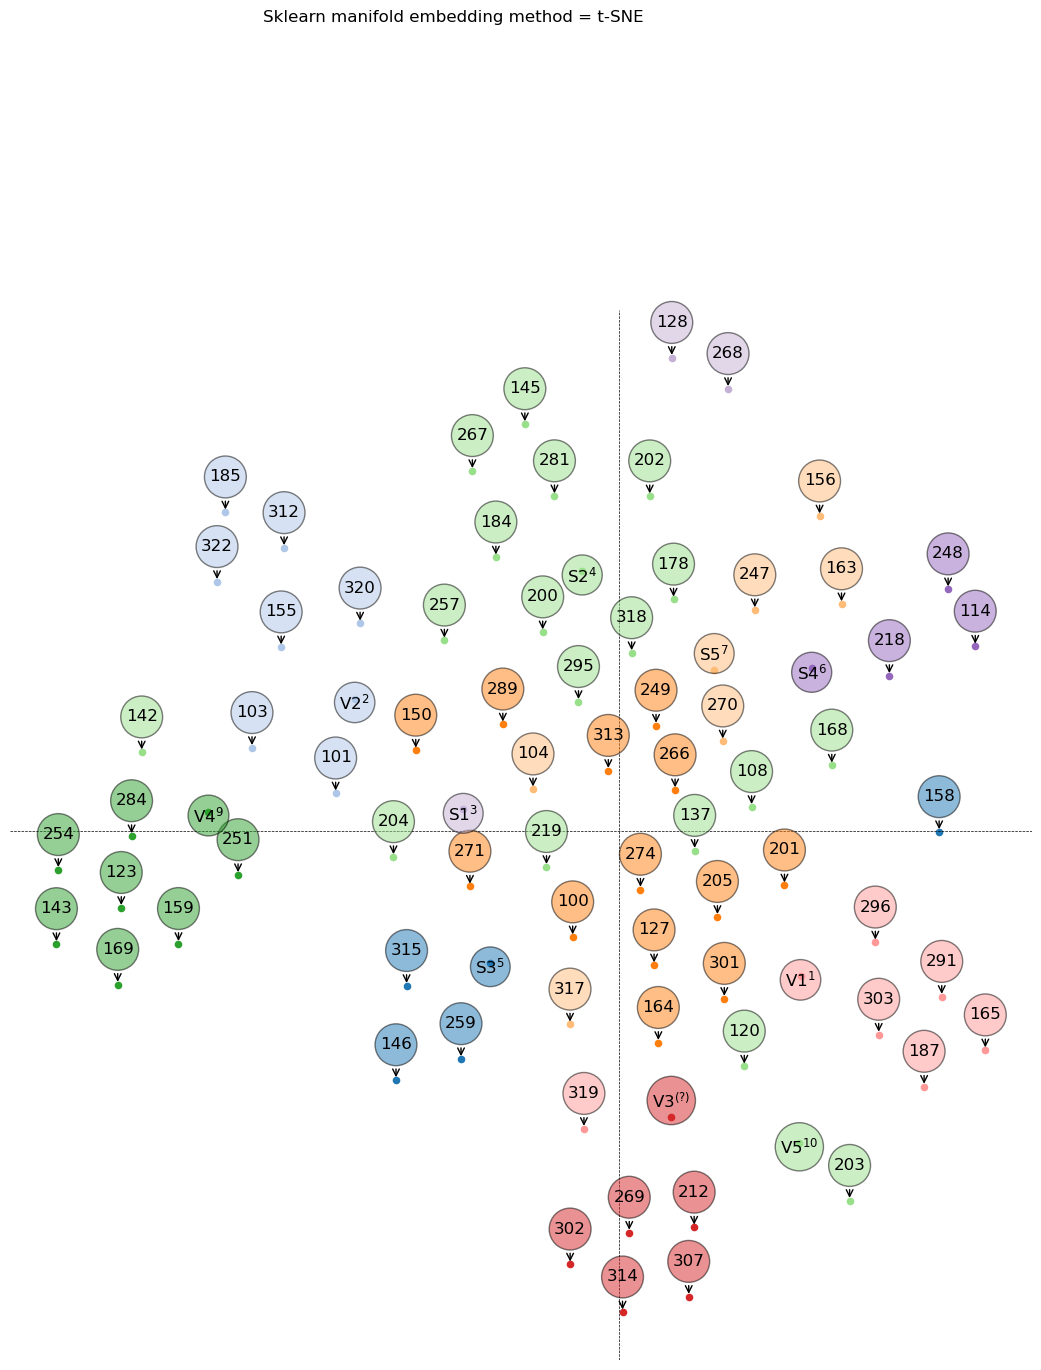

In [10]:
"""Plot and Save figure"""
from Methods.figure_settings import Display
Inertia = np.array([0, 1]) # not relevant for manifold
AllCols = ContDataFrame.columns
AllRows = ContDataFrame.index

col_rows = {rows_labels[ContDataFrame.index[i]]:color_clustered[i] for i in range(M)}

if (Orow is not None) or (Ocols is not None):
    col_cols = {columns_labels[ContDataFrame.columns[i]]:color_clustered[i+M+1] for i in range(N)}
else:
    col_cols = {columns_labels[ContDataFrame.columns[i]]:color_clustered[i+M] for i in range(N)}
    Origin_manifold = None # Not interpretable thus not plotted
col_to_use = (col_rows, col_cols)
marker_to_use = [("o",20),("o",20)]
fig, xy_rows, xy_cols, gs, center = Display(Rows_manifold, 
                                             Cols_manifold, 
                                             Inertia, 
                                             ContDataFrame,
                                             center = Origin_manifold, 
                                             rows_to_Annot = AllRows,  # row items to annotate, if None then no annotation (None if none)
                                             cols_to_Annot = AllCols,  # column items to annotate (None if none)
                                             Label_rows = rows_labels, # dictionary of labels respectivelly corresponding to the row items (None if none)
                                             Label_cols = columns_labels,     # dictionary of labels respectivelly corresponding to the column items that (None if none)
                                             markers = marker_to_use,# pyplot markertypes, markersize: [(marker for the row items, size), (marker for the columb items, size)] 
                                             col = col_to_use,        # pyplot colortypes : [color for the row items, color for the column items] 
                                             figtitle = "Sklearn manifold embedding method = %s"%low_meth, 
                                             outliers = (True, True),
                                             dtp = dtp,
                                             chosenAxes = np.array([0,1]), 
                                             show_inertia = False, 
                                             model={"model":"stand"}, 
                                             ColName = ColName, 
                                             RowName = RowName,
                                             lims = False) # crop fig

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
pdf= PdfPages("Figures/fig%s_%s_tSNE"%(col_val,row_val)+".pdf")
pdf.savefig(fig, bbox_inches = "tight")
pdf.close()
plt.show()